In [3]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")


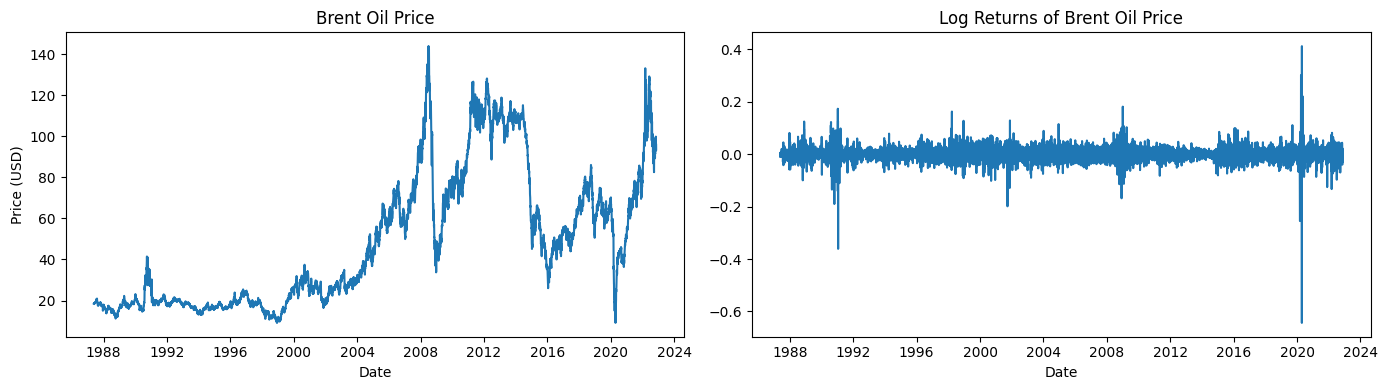

In [6]:
# 2. Load and preprocess data
# Replace this path with your actual file path
df = pd.read_csv("../data/BrentOilPrices.csv")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)

# Calculate log returns
df['LogReturn'] = np.log(df['Price']) - np.log(df['Price'].shift(1))
df = df.dropna().reset_index(drop=True)

# Visualize original price and log return
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(df['Date'], df['Price'])
plt.title("Brent Oil Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")

plt.subplot(1, 2, 2)
plt.plot(df['Date'], df['LogReturn'])
plt.title("Log Returns of Brent Oil Price")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


In [7]:
# 3. Bayesian Change Point Model using PyMC3
log_returns = df['LogReturn'].values
n = len(log_returns)

with pm.Model() as model:
    # Switchpoint: change point in time
    tau = pm.DiscreteUniform('tau', lower=0, upper=n)

    # Parameters before and after tau
    mu_1 = pm.Normal('mu_1', mu=0, sigma=1)
    mu_2 = pm.Normal('mu_2', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Mean changes at tau
    mu = pm.math.switch(tau >= np.arange(n), mu_1, mu_2)

    # Likelihood
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=log_returns)

    # Sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.95, random_seed=42, return_inferencedata=True)


NameError: name 'pm' is not defined

In [8]:
# 4. Diagnostics & Posterior Visualization
az.plot_trace(trace, var_names=["tau", "mu_1", "mu_2"])
plt.show()

az.summary(trace, var_names=["tau", "mu_1", "mu_2"])


NameError: name 'az' is not defined

In [9]:
# 5. Interpreting the change point result
# Get the most probable change point (mode of tau posterior)
tau_posterior = trace.posterior['tau'].values.flatten()
tau_est = int(np.round(np.mean(tau_posterior)))  # mean or mode can be used

change_date = df.loc[tau_est, 'Date']
print(f"Estimated Change Point: Index = {tau_est}, Date = {change_date.date()}")

# Quantify mean difference
mu_1_samples = trace.posterior['mu_1'].values.flatten()
mu_2_samples = trace.posterior['mu_2'].values.flatten()
mu_1_mean = mu_1_samples.mean()
mu_2_mean = mu_2_samples.mean()
impact_percent = (mu_2_mean - mu_1_mean) / abs(mu_1_mean) * 100

print(f"Mean log return before change point: {mu_1_mean:.6f}")
print(f"Mean log return after change point: {mu_2_mean:.6f}")
print(f"Estimated impact: {impact_percent:.2f}% change")


NameError: name 'trace' is not defined

NameError: name 'change_date' is not defined

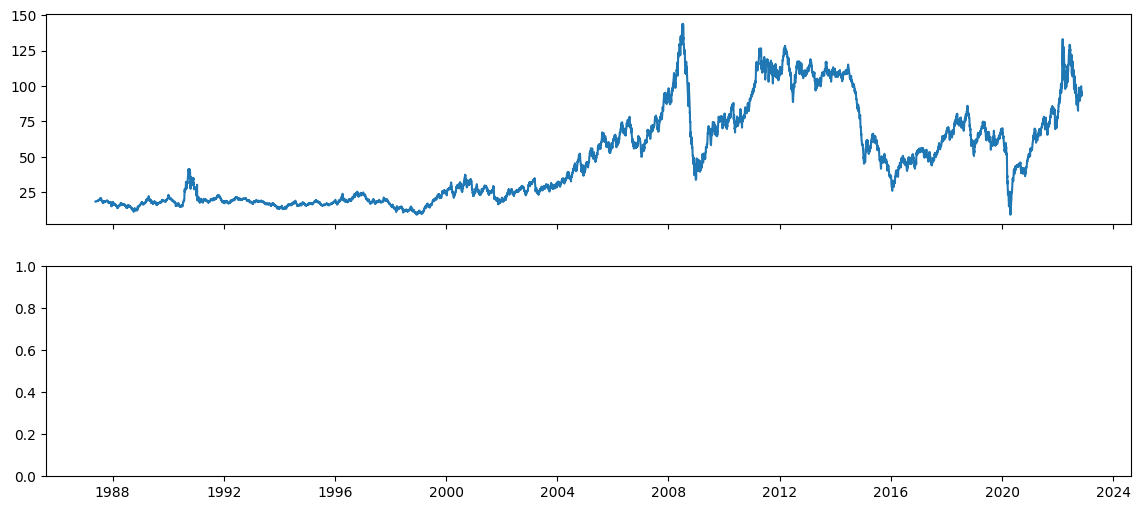

In [10]:
# 6. Visualize change point on price and return series
fig, ax = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

ax[0].plot(df['Date'], df['Price'])
ax[0].axvline(change_date, color='red', linestyle='--', label='Change Point')
ax[0].set_title("Brent Oil Price with Change Point")
ax[0].legend()

ax[1].plot(df['Date'], df['LogReturn'])
ax[1].axvline(change_date, color='red', linestyle='--', label='Change Point')
ax[1].set_title("Log Returns with Change Point")
ax[1].legend()

plt.tight_layout()
plt.show()
